In [1]:
### https://gitlab.ethz.ch/socceranalytics/uefa-euro-2020/-/snippets/557
# 557

import json
from zipfile import ZipFile
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplsoccer as mpls

In [2]:
# ----- classes ----- #
# we used this classes to read in the wyscout data
class Wyscout_all:
    provider = 'wyscout'
    pitch_dims = (100, 100)

    def __init__(self, path, match_id):
        self.path = path
        self.match_id = match_id
        self.events = self.load_events()
        self.event_types = pd.unique([event['type']['primary'] for event in self.events])
        self.shots = self.get_event_df('shot')
        self.passes = self.get_event_df('pass')

    def load_events(self):
        file = self.path + str(self.match_id) + "_events.json"
        if not os.path.isfile(file):
            with ZipFile(self.path + str(self.match_id) + ".zip", 'r') as f:
                f.extractall(self.path)
        return json.load(open(file))['events']

    def get_event_df(self, event_type: str):
        return pd.json_normalize([event for event in self.events if event['type']['primary'] == event_type])


# ----- functions ----- #

def probabDefense(loc,sum):
    # creating 100 zones inside of the first half of the field

    # create an array of the right size with zero
    my_array = np.zeros((5, 5))

    # loop in the array
    ran = range(5)
    for i in ran:
        for j in ran:
            count = 0
            for k in range(len(loc)):
                if loc[k][0] <= 49:
                    if int(loc[k][0] / 10) == j and int(
                            loc[k][1] / 20) == i:  # add the value if coordinate match
                        count += 1
            my_array[i, j] += count  # add the value to array
    my_array = my_array / sum
    return my_array


def defense(wyscout,team,t):
    loc=[]

    # interceptions
    interceptions= wyscout.get_event_df('interception')
    for i in range(len(interceptions)):
        if interceptions.iloc[i,18] == team[t]:
            loc.append([interceptions.iloc[i,15],interceptions.iloc[i,16]])

    #duels
    duel= wyscout.get_event_df('duel')
    for i in range(len(duel)):
        if duel.iloc[i,18] == team[t]:
            for j in range(len(duel.iloc[i,14])):
                if duel.iloc[i,14][j] == 'defensive_duel':
                    status=False
                    for k in range(len(duel.iloc[i,14])):
                        if duel.iloc[i,14][k] == 'recovery':
                            loc.append([duel.iloc[i,15],duel.iloc[i,16]])
                            status=True
                    if status == False and duel.iloc[i,33]==True:
                        loc.append([duel.iloc[i,15],duel.iloc[i,16]])

    # clearances
    clear=wyscout.get_event_df('clearance')
    for i in range(len(clear)):
        if clear.iloc[i,18] == team[t]:
            loc.append([clear.iloc[i,15],clear.iloc[i,16]])

    return loc


def baddefense(wyscout,team,t):
    loc=[]

    duel= wyscout.get_event_df('duel')
    for i in range(len(duel)):
        if duel.iloc[i,18] == team[t]:
            for j in range(len(duel.iloc[i,14])):
                if duel.iloc[i,14][j] == 'defensive_duel':
                    status=False
                    for k in range(len(duel.iloc[i,14])):
                        if duel.iloc[i,14][k] == 'recovery':
                            status=True
                    if status == False and duel.iloc[i,33] == False:
                        loc.append([duel.iloc[i,15],duel.iloc[i,16]])
    if t==0:
        loc.append([6,52])
    return loc

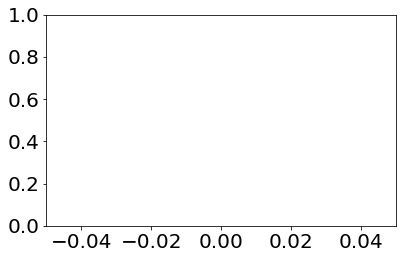

In [6]:
# ----- plotting params ----- #

colors = ['#db2c2c', '#2e68c7', '#006400', '#FAC205']

'''
plt.rcParams.update({'font.family': 'sans-serif'})
plt.rcParams.update({'font.sans-serif': 'yu gothic'})
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'mathtext.fontset': 'dejavuserif'})
plt.rcParams.update({'figure.autolayout': True})
'''

plt.autoscale(enable=True, axis='x', tight=True)
figsize = (24, 12)

# -----  plotting functions ----- #

def PlotDefense(location_list,team,t,word):
    pitch = mpls.Pitch(pitch_type='wyscout', pitch_color='#aabb97', line_color='white', stripe_color='#c2d59d',
                       stripe=True, figsize=figsize)
    fig, ax = pitch.draw()
    if t==0:
        for i in range(0, len(location_list[t])):
            loc = location_list[t][i]
            ax.plot(loc[0], loc[1], marker='o', color=colors[0], alpha=0.5, ls='')
    else:
        for i in range(0, len(location_list[t])):
            loc = location_list[t][i]
            ax.plot(loc[0], loc[1], marker='o', color=colors[1], alpha=0.5, ls='')
    ax.set_title(word + ' Defensive Actions of '+team[t], fontsize=18)
    plt.savefig(f"Defense{team[t]}{word}.png",dpi=400)
    plt.show()
    

def somelines(x1, x2, y1, y2, colors, i):
    plt.plot([x1, x2], [y1, y1], linewidth=3, color=colors[i])
    plt.plot([x1, x2], [y2, y2], linewidth=3, color=colors[i])
    plt.plot([x1, x1], [y1, y2], linewidth=3, color=colors[i])
    plt.plot([x2, x2], [y1, y2], linewidth=3, color=colors[i])


def DefHeatmap(my_array,team,t,word):
    a = plt.imshow(my_array, cmap='viridis', alpha=0.5)
    plt.colorbar()
    # plotting football field
    colors = ['white']
    somelines(-0.5, 4.5, -0.5, 4.5, colors, 0)
    somelines(-0.5, 1.1, 0.45, 3.55, colors, 0)
    somelines(-0.5, 0.1, 1.35, 2.65, colors, 0)
    plt.plot(0.5, 2, marker='o', linewidth=3, color=colors[0])
    plt.plot(4.5, 2, marker='o', linewidth=3, color=colors[0])
    circle1 = plt.Circle((4.5, 2), 0.75, fill=False, color=colors[0], linewidth=3)
    x1,x2= 1.1, 1.1
    y1,y2=2.65,1.35
    plt.plot([x1,x2],[y1,y2],".",alpha=0)
    plt.annotate(
        "",
        xy=(x1, y1),
        xycoords="data",
        xytext=(x2, y2),
        textcoords="data",
        arrowprops=dict(
            arrowstyle="-",
            color=colors[0],
            linewidth=3,
            patchB=None,
            shrinkB=2,
            connectionstyle="arc3,rad=-0.5",
        ),
    )
    plt.gcf().gca().add_artist(circle1)
    a.axes.get_xaxis().set_visible(False)
    a.axes.get_yaxis().set_visible(False)
    a.axes.get_xaxis().set_ticks([])
    a.axes.get_yaxis().set_ticks([])
    plt.title(word +' Defensive Heat Map of '+team[t], fontsize=18)
    plt.savefig(f"DefHeatmap{team[t]}{word}.png",dpi=400)
    plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: yu gothic


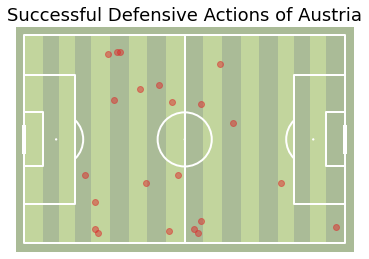

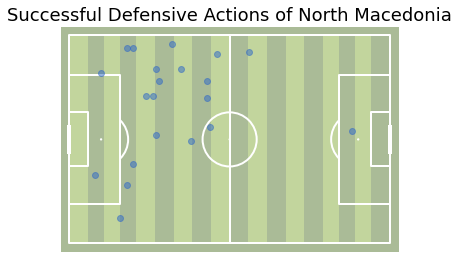

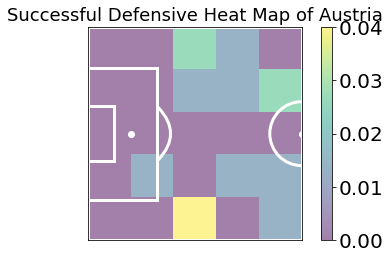

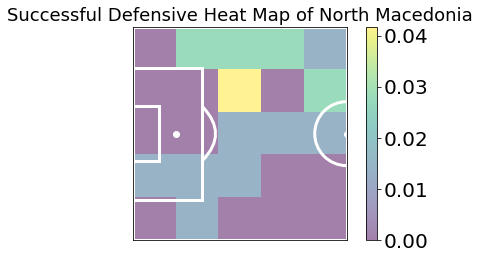

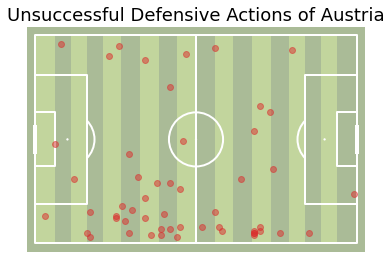

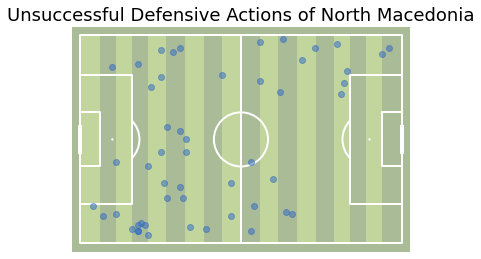

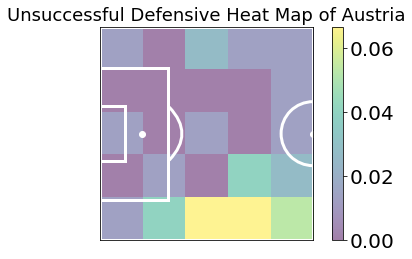

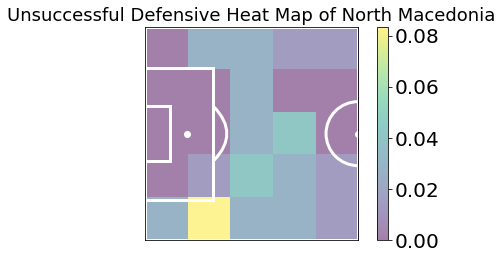

In [8]:
# -----  main ----- #
wyscout2 = Wyscout_all("../../data/wyscout/5111384/", 5111384)
team=['Austria','North Macedonia']
word=['Successful','Unsuccessful']

loc_def=[defense(wyscout2,team,0),defense(wyscout2,team,1)]
loc_baddef=[baddefense(wyscout2,team,0),baddefense(wyscout2,team,1)]
sum=[len(loc_baddef[0])+len(loc_def[0]),len(loc_baddef[1])+len(loc_def[1])]
defense_array=[probabDefense(loc_def[0],sum[0]),probabDefense(loc_def[1],sum[1])]
baddefense_array=[probabDefense(loc_baddef[0],sum[0]),probabDefense(loc_baddef[1],sum[1])]

PlotDefense(loc_def,team,0,word[0])
PlotDefense(loc_def,team,1,word[0])
DefHeatmap(defense_array[0],team,0,word[0])
DefHeatmap(defense_array[1],team,1,word[0])

PlotDefense(loc_baddef,team,0,word[1])
PlotDefense(loc_baddef,team,1,word[1])
DefHeatmap(baddefense_array[0],team,0,word[1])
DefHeatmap(baddefense_array[1],team,1,word[1])